Copyright (C) 2024 Konstantin Touev  
All Rights Reserved.

TODO: Cite dataset https://huggingface.co/datasets/retkowski/ytseg

Do the imports -> we use the standard project imports as we verify project solutions 

In [110]:
import datetime
from IPython.display import display

from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field

if __name__ == "__main__":
    from dotenv import load_dotenv

    load_dotenv()

import pandas as pd
from pandas import Timedelta
from langchain import PromptTemplate
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download

from file_processing.document_processor.summarisation_utils import chunk_into_semantic_chapters
from file_processing.embeddings import pending_embeddings_singleton, BGEM3Flag
from file_processing.llm_chat_support import get_llm, LLMTemp, LLMTypes

Prepare dataset and tools

In [111]:
# First load the CSV
# Originally from https://huggingface.co/datasets/recapper/Course_summaries_dataset
# I choose this dataset as it had timestamped transcriptions and human-entered chapters for the videos

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
# Read the whole text fields
pd.set_option('display.max_colwidth', None)

yt_transcript_path = hf_hub_download(repo_type="dataset", repo_id="retkowski/ytseg", filename="data/yt_seg_titles.json")
data_df = pd.read_json(yt_transcript_path, orient='records', lines=True)

video_urls = data_df['video_id']

# 19 per group is calculated using power test for sample_size = 12
# H0 was already rejected, but using the suggested minimum sample size is good!
sample_size = round(19 * 2.5)
video_urls = video_urls.sample(n=sample_size).sort_values().tolist()

print(f"We have {len(video_urls)} videos in dataset:")
display(pd.DataFrame({'VideoURL': video_urls[:]}))

human_chapters_transcript_data = []
for video_url in video_urls:
    human_chapters_per_video_df = data_df[data_df['video_id'] == video_url]
    for _, row in human_chapters_per_video_df.iterrows():
        human_chapters_transcript_data.append({
            'video_url': video_url,
            'title': row['target'],
            'chapter_text': row['input']
        })
human_chapters_transcript_df = pd.DataFrame(human_chapters_transcript_data)

#print("Transcripts for video:")
#display(transcripts_df)
#print("Human chapters for video:")
#display(human_chapters_df)
print("Human chapters and their transcript per video:")
display(human_chapters_transcript_df)

# Define LLM-globals
class ScoreFormat(BaseModel):
    rating: int = Field(description="Rating from 0 to 100")
    arguments: str = Field(description="Arguments explaining why the rating was chosen")


structured_model = (get_llm(LLMTemp.CONCRETE, LLMTypes.BIG_VISUAL_MODEL)
                    .with_structured_output(ScoreFormat, method="json_mode"))

pending_embeddings_singleton.init_mode(BGEM3Flag())

output_parser = PydanticOutputParser(pydantic_object=ScoreFormat)

We have 48 videos in dataset:


,VideoURL
0,-xjZ54TFT2o
1,2XGREPnlI8U
2,2kYqITsbK5U
3,3-mLD6JBfl8
4,3yiT_WMlosg
5,423Hu1I5wa8
6,53nDh4_GhA8
7,6R179MBYMhY
8,8bL050WTT1s
9,BuBDmIRThtk


Human chapters and their transcript per video:


video_url                                            title  \
0    -xjZ54TFT2o                                            Intro   
1    -xjZ54TFT2o               What Companies Claim They're Doing   
2    -xjZ54TFT2o                          Why Companies Greenwash   
3    -xjZ54TFT2o                   Why Corporations Won't Save Us   
4    -xjZ54TFT2o                                    How We Change   
..           ...                                              ...   
587  z0e76N-wMz0  Types of waves (longitudinal, transverse, etc.)   
588  z0e76N-wMz0                                     Interference   
589  z0e76N-wMz0                                   Standing waves   
590  z0e76N-wMz0                                   Doppler effect   
591  z0e76N-wMz0                                      Shock waves   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

Fetching 30 files: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35128.17it/s]
/u/halle/tou/home_at/IdeaProjects/thesis_backend/venv/lib/python3.10/site-packages/FlagEmbedding/BGE_M3/modeling.py:335: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` fo

For evaluation, we do 4 things -> titles for semantic chapter, rate human titles, rate chapter division and evaluate semantic vs human chapters directly.

Step 1: Generate titles for the semantic chapter  
We do that so we have a human-readable representation of the split

In [112]:
from langchain_core.messages import AIMessage

semantic_chapter_df = pd.DataFrame(columns=['video_url', 'title', 'chapter_text'])

for video_url in list(video_urls):
    try:
        transcripts_video_df = human_chapters_transcript_df[
            (human_chapters_transcript_df['video_url'] == video_url)
        ]
        # Sometimes we have wrong datatype for transcript
        transcript_text = ' '.join(transcripts_video_df['chapter_text'].tolist())
        
        # Use default chunk size
        semantic_chapters = chunk_into_semantic_chapters(pending_embeddings_singleton, transcript_text)
        
        title_generation_prompt = PromptTemplate(
            input_variables=['chapter_text'],
            template="""
        Given the following chapter text, generate a concise and descriptive title for it.
        
        Chapter Text:
        {chapter_text}
        
        Title:
        """
        )
        
        semantic_chapter_per_video_data = []
        for idx, chapter_text in enumerate(semantic_chapters):
            title_msg: AIMessage = (
                        title_generation_prompt | get_llm(LLMTemp.CONCRETE, LLMTypes.BIG_VISUAL_MODEL)).invoke({
                "chapter_text": chapter_text
                # Title sometimes has quotes or may be using md formatting
            })
            title = title_msg.content.strip().strip('"').strip("'").strip('*')
            semantic_chapter_per_video_data.append({
                'video_url': video_url,
                'title': title,
                'chapter_text': chapter_text
            }) 
            
        semantic_chapter_per_video_df = pd.DataFrame(semantic_chapter_per_video_data)
        # print(f"Semantic chapters and their transcripts for video '{video_url}':")
        # display(semantic_chapter_per_video_df)
        print(f"Semantic chapters for video '{video_url}':")
        print(', '.join(semantic_chapter_per_video_df["title"].apply(lambda x: (x[:25] + '...') if len(x) > 30 else x).tolist()))
        semantic_chapter_df = pd.concat([semantic_chapter_df, semantic_chapter_per_video_df]).reset_index(drop=True)
    except Exception as e:
        print(f"Failed to add video '{video_url}' semantic chapters")
        print(e)
        video_urls.remove(video_url)
    

# print(f"Semantic chapters and their transcript per video:")
# display(semantic_chapter_df)

Semantic chapters for video '-xjZ54TFT2o':
Unmasking Greenwashing: T..., Greenwashing: The Corpora..., Greenwashing and the Illu..., Corporate Greenwashing: T..., Unmasking Greenwashing: T..., Building a Sustainable Fu..., Farewell and See You Soon


Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 674/674 [00:23<00:00, 29.22it/s]


Semantic chapters for video '2XGREPnlI8U':
Understanding Healthy and..., The Science and Appeal of..., Optimizing Feeding Window..., Exploring Fasting, Eating..., Impact of Meal Timing on ..., Optimizing Muscle Growth:..., Optimizing Muscle Growth:..., Impact of Circadian Rhyth..., Optimizing Muscle Protein..., Optimizing Protein Intake..., Promoting Ethical and Nut..., Enhancing Wellness: Medit..., Boosting Wellness: The Be..., Understanding Eating Diso..., The Dangers and Symptoms ..., Anorexia Nervosa: Histori..., Understanding Eating Diso..., The Evolving Landscape of..., Understanding Eating Diso..., Understanding Hunger and ..., Neural and Chemical Regul..., AgRP Neurons: The Drivers..., AgRP Neurons, Appetite Re..., The Role of Leptin in Rep..., The Biological Mechanisms..., Understanding the Complex..., Evolutionary Perspectives..., Sibling Rivalry and the N..., Understanding Behavioral ..., The Disconnect Between Ho..., Understanding Anorexia: B..., Anorexia and Puberty: Unr..

Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 248/248 [00:09<00:00, 27.51it/s]


Semantic chapters for video '3-mLD6JBfl8':
Leveraging Social Media f..., Patch Dulay: From Global ..., Sparking Goodness: Empowe..., Modern Crowdfunding: Revo..., Understanding the Types o..., Understanding Crowdfundin..., Exploring Crowdfunding St..., Empowering Communities Th..., Unlocking the Multifacete..., Building Community and Ra..., Unlocking Opportunities: ..., Crowdfunding: Empowering ..., Key Elements for a Succes..., Essential Strategies for ..., Essential Considerations ..., Keys to Successful Crowdf..., Launching Your Crowdfundi..., Mastering Crowdfunding: S..., Maximizing Crowdfunding S..., Navigating Social Media a..., Navigating Crowdfunding f..., Choosing the Right Crowdf..., Navigating Crowdfunding: ..., Effective Crowdfunding St..., Effective Strategies for ..., Maximizing Transparency i...


Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:10<00:00, 36.11it/s]


Semantic chapters for video '3yiT_WMlosg':
Exploring Realistic Hacki..., Exploring the Complexitie..., Hacking the Industrial Wo..., Desperate Measures: The R..., Inside the Network: The R..., Exploits and Evasion: Ell..., Cracking WPA2: The Challe..., Cracking WPA2 and Infiltr..., Bluetooth Hacking and Con..., Exploring Bluetooth Devic..., Prioritizing Audience Req..., Exploiting Bluetooth Vuln..., Bluetooth Spoofing: Real-..., Bluetooth Spoofing: Hacki..., Understanding PLCs and La..., Decoding Cyber Intrusions..., Unsecured Access: Explori..., Vulnerabilities in Online..., Exploiting Vulnerabilitie..., Hacking Courses and Ethic..., Hacking Adventures: Explo...
Semantic chapters for video '423Hu1I5wa8':
Stairway to Wealth: The P..., Maximizing Wealth Through..., Why Free Trade and Non-In..., The Role of Government in..., The Evolution of Power: F..., Principles of Fair Govern..., Principles of Fair Taxati...
Semantic chapters for video '53nDh4_GhA8':
Understanding Elastic and..., Ine

Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 783/783 [00:22<00:00, 35.24it/s]


Semantic chapters for video 'BuBDmIRThtk':
The Science of Spirituali..., The Intersection of Scien..., Defining Spirituality: Th..., Bridging the Divide: Reco..., Awakened Minds: Human and..., Rediscovering Our Innate ..., Embracing Spiritual Aware..., Exploring the Intersectio..., Overcoming Bias: The Need..., Awakening Through Conscio..., Awakening Through Sufferi..., Reawakening Inner Wisdom:..., Spiritual Resilience: The..., Spiritual Awareness: A Pr..., Integrating Spiritual Awa..., Awakening Compassion and ..., Inner Council: A Guided V..., Transforming Lives: The P..., Building Spiritual Readin..., Transforming Transactiona..., Rediscovering Ancient Wis..., Reviving Duty and Connect..., Awakened Leadership: The ..., Exploring the Neuroscienc..., Operationalizing Spiritua..., Neural Correlates of Spir..., From Mindfulness to Awake..., From Red Doors to Yellow ..., Aligning Heart and Mind: ..., Heart vs. Head: Reclaimin..., Adolescence: A Window to ..., The Quest for Transcenden..

Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 130/130 [00:04<00:00, 31.45it/s]


Semantic chapters for video 'DrJt_NAD8IA':
Self-Destructive Microbes..., Earth's Rarity and the Qu..., Hubble Tension: Unravelin..., Unraveling Mysteries: Wha..., Genetic Resilience and Co..., Sleep Duration and Chroni..., Smiling and Happiness: In...


Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 212/212 [00:07<00:00, 28.18it/s]


Semantic chapters for video 'EJ_7Gx6amt8':
Dense Retrieval and Knowl..., Advancements in Neural Re..., Optimizing Search with De..., Optimizing BERT DOT for E..., Optimizing Training with ..., Optimizing Nearest Neighb..., Advancements in Dense Ret..., Enhancing Model Training ..., Optimizing Information Re..., Optimizing Information Re..., Optimizing Dense Retrieva..., Optimizing Query Sampling..., Optimizing Dense Retrieva..., Challenges and Solutions ..., Rapid Advancements in Zer..., Evaluating Lexical Overla..., Evaluating Lexical Matchi..., Evaluating Dense Retrieva..., Farewell
Semantic chapters for video 'GzHDiXjHSsU':
Essential Foods Seniors S..., Healthy Eating Tips for S..., Healthy Eating Alternativ..., Health Risks of Alcohol a..., Healthy Eating Tips for S...


Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 135/135 [00:03<00:00, 35.51it/s]


Semantic chapters for video 'K2WnW4cFQww':
Unveiling the Truth About..., The Sugar-Loving Microbes..., The Hidden Battle in Your..., Hidden Dental Dangers: Ev..., Healthy Snacking and Hydr...


Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 163/163 [00:05<00:00, 30.50it/s]


Semantic chapters for video 'LafQRvFQHls':
Political Tensions and Un..., Rising Tensions: The Thre..., Geopolitical Tensions and..., Kosovo's Path to NATO and..., Navigating Democracy and ..., Establishing Reciprocity:..., Kosovo's Democratic Strug..., Strengthening Democracy a..., Challenges to Press Freed..., Justice Delayed: The Stru..., Unequal Justice: War Crim...


Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 170/170 [00:06<00:00, 27.27it/s]


Semantic chapters for video 'Ld8ha3AgfW0':
Arthur Schopenhauer: The ..., Schopenhauer: A Life of P..., Schopenhauer's Struggle: ..., Schopenhauer: The Lonely ..., The Essence of Existence:..., Schopenhauer's Philosophy..., The Unrelenting Will: Sch..., The Unconscious Will: Sch..., Schopenhauer's Philosophy..., The Tragicomedy of Human ..., Schopenhauer's Pessimism:..., Schopenhauer's Philosophi..., The Wisdom of Life: Schop..., Transcendence Through Art...


Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 306/306 [00:08<00:00, 34.98it/s]


Semantic chapters for video 'MxT6IwUtLSU':
The Phenomenon of Super M..., Super Mario Bros.: The Ga..., Crafting a Classic: The C..., Revolutionizing Mario: Th..., Crafting a Magical World:..., The Guiding White Castle:..., Power-Ups and Enemies: Th..., Crafting the Ultimate Mar..., Super Mario Bros. 3: A Ga..., Super Mario Mania: Ninten..., From Doki Doki Panic to S..., Behind the Scenes: The Jo..., Super Mario Bros. 3: The ..., The Wizard and the Rise o..., The Frenzy of Super Mario..., Super Mario Bros. 3: The ..., Super Mario Bros. 3: A Re...


Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:04<00:00, 32.94it/s]


Semantic chapters for video 'N5MUlw7oVVg':
Navigating Ember and Grap..., Introduction to GraphQL Q..., Understanding Apollo Clie..., Optimizing User Data Fetc..., Implementing Efficient Ca..., Efficient Caching and Rea..., Efficient Resource Manage..., Implementing Reactive Dat...


Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [00:08<00:00, 31.05it/s]


Semantic chapters for video 'NYZOngyZvaI':
Unveiling the Overlooked ..., Unveiling Mario: An In-De..., From Radar Scope to Donke..., Subverting Clichés: Mario..., Game & Watch: Misundersto..., Questioning Mario's Moral..., Reevaluating Mario: The M..., From Blank Slate to Brave..., Unveiling Mario Bros. (Ga..., Dual-Screen Delivery: Mar..., Gameplay Mechanics and Fe..., Unpacking Mario Bros.: Th..., The Unending Labor of Mar..., Exploiting the Working Cl..., The Canonical Ending: Exp..., Endless Labor and Capital..., Reimagining Classics: Nin..., From Bottling Plant to Ca..., Wario and Bowser: Narrati..., Forgotten Beginnings: The...


Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:07<00:00, 33.59it/s]


Semantic chapters for video 'OA28SYILJv8':
Understanding Constant Va..., Understanding Console Inp..., Handling User Input and D..., Handling Invalid Input an..., Handling Invalid Input an..., Handling Invalid Input in..., Debugging and Recompiling..., Handling Console Input Er..., Handling Input Errors and..., Handling Console Input an..., Building a Simple Calcula..., Handling Input Errors and..., Understanding Data Types:..., Conclusion and Next Steps...


Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 161/161 [00:05<00:00, 29.69it/s]


Semantic chapters for video 'QAJbWwNlIJ8':
Dynamic Programming: Solv..., Challenges and Limitation..., Optimizing Recursive Solu..., Optimizing Recursive Algo..., Optimizing Recursive Tree..., Optimizing Dynamic Progra..., Optimizing Recursive Algo..., Optimizing Recursive Subs..., Optimizing Memoization: E..., Optimizing Subset Sum Rec..., Understanding Pseudo-Poly..., Embracing the Learning Cu...
Semantic chapters for video 'QVdXrZcmaiM':
Top 5 Career-Boosting Ski..., Choosing Your Career Path..., Essential Skills for Mode..., Essential Networking and ..., Essential Skills for Futu..., Engage, Subscribe, and Su...
Semantic chapters for video 'RRrWXfSdVps':
Asparagus: A Nutrient-Den..., Farewell and Future Conte...
Semantic chapters for video 'TyAmoIeaN9E':
Impact of Public Outcry o..., Unveiling the TRP Scam: L..., Revelations and Allegatio..., Exposing Media Manipulati..., Alleged TRP Manipulation ..., Controversial Leaked Chat..., Support and Share: Amplif...


Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 550/550 [00:21<00:00, 25.83it/s]


Semantic chapters for video 'UF0nqolsNZc':
Optimizing Health Through..., Phototherapy: A Century o..., Enhancing Visual Health w..., Promoting Health and Scie..., Optimizing Health and Per..., Personalized Nootropics a..., Illuminating Light: Under..., Understanding the Impact ..., Beyond Visible: The Hidde..., Understanding Light: Wave..., Deep Tissue Light Absorpt..., Cellular Organelles: Stru..., Precision of Light: Harne..., Understanding Rods and Co..., Understanding Light Absor..., How Light Influences Cell..., Light as a Biological Com..., Light and Its Profound Im..., The Earth's Orbit and Its..., Melatonin: Nature's Light..., Melatonin: Natural Produc..., Melatonin: Its Impact on ..., Melatonin: The Multifacet..., Optimizing Sunlight Expos..., Seasonal Rhythms: The Imp..., Optimizing Light Exposure..., The Role of Melatonin in ..., Light's Influence on Horm..., Impact of UVB Light Expos..., Translating UV Exposure E..., Establishing Baseline Hor..., Impact of UVB Sunlight Ex..

Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 174/174 [00:05<00:00, 32.33it/s]


Semantic chapters for video 'WNj9PmDIp1U':
Understanding Inductance:..., Understanding Electromagn..., Understanding Inductance ..., Understanding Inductance:..., Understanding Electrical ..., Deriving Inductance in Id..., Understanding Inductance ..., Analyzing Energy Dynamics..., Deriving Energy Storage i..., Gratitude for Shared Learning


Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 318/318 [00:09<00:00, 34.34it/s]


Failed to add video 'XoeR2pkZWdg' semantic chapters
Azure has not provided the response due to a content filter being triggered


Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 626/626 [00:20<00:00, 31.19it/s]


Semantic chapters for video 'ZjAMRnCu-84':
Transitioning from Flask ..., Introduction to Django: B..., Understanding Key Django ..., Setting Up Routes and App..., Understanding Django View..., Organizing Django Routes:..., Setting Up URL Routing in..., Integrating App URLs with..., Launching Your First Djan..., Building and Evolving Dat..., Configuring Django Apps a..., Understanding Django Migr..., Automating Database Migra..., Using Django Shell for Da..., Enhancing Flight Data Rep..., Implementing Foreign Key ..., Managing Airport and Flig..., Integrating Database Mode..., Integrating Django Templa..., Understanding Template Na..., Streamlining Data Managem..., Exploring Django's Built-..., Effortless Data Managemen..., Understanding and Customi..., Handling Dynamic URL Para..., Implementing Dynamic Flig..., Implementing Named URL Ro..., Implementing Django URL R..., Organizing HTML with Djan..., Designing Many-to-Many Re..., Introducing the Passenger..., Automating Database Migra..

Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 146/146 [00:04<00:00, 31.00it/s]


Semantic chapters for video 'cTrUrOIWz8Y':
Unifying Data: Exploring ..., Navigating Supply and Dem..., Revolutionizing Inventory..., Enhancing Supply Chain Vi..., Real-Time Inventory Manag..., Integrating Machine Learn..., Transforming B2B to B2C: ..., Enhancing Customer Suppor..., Unlocking Potential with ...


Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 157/157 [00:04<00:00, 31.90it/s]


Semantic chapters for video 'fH6obcnOhVI':
Understanding Kidney Ston..., Understanding Kidney Ston..., Hydration and Diet: Key F..., Understanding Kidney Ston..., Hydration, Gender Dispari..., Kidney Stone Management: ..., Top Strategies for Preven..., Balancing Diet and Kidney...


Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 135/135 [00:04<00:00, 31.63it/s]


Semantic chapters for video 'fnLwBz1Cegk':
Enhancing Operational Eff..., Modernizing Legacy System..., Efficient Scaling and Dat..., Revolutionizing Customer ..., Transforming Inventory Vi..., Optimizing Data Performan..., Subscribe for More: Stay ...
Semantic chapters for video 'ggnl4UwYMog':
Top 10 Essential Tasks fo..., Top 10 Essential SAS Viya..., Monitoring System Perform..., Effective SAS Viya Admini..., Essential Strategies for ..., Essential Maintenance and..., Orchestrating SAS Viya Se..., Optimizing SAS Viya Admin..., Engage with SAS Technical...
Semantic chapters for video 'hpliG_-G5nU':
Securing APIs with Google..., Getting Started: Follow t...
Semantic chapters for video 'lvW3Ax9LwAA':
Big Navi: AMD's Leap Towa..., Big Navi Performance Prev..., Big Navi vs. Geforce: AMD..., Evaluating Big Navi: Perf..., Big Navi vs. Nvidia: The ..., Managing Expectations for...


Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 156/156 [00:05<00:00, 30.69it/s]


Semantic chapters for video 'm5ioojZQYM0':
Implementing a Spell Chec..., Efficient Data Retrieval ..., Building and Understandin..., Inserting and Managing No..., Implementing Tries for Di..., Efficient Word Insertion ..., Efficient Memory Manageme..., Optimizing Speller PSet: ...
Semantic chapters for video 'm8KJV5TmTi0':
The Evolution of Mary-Kat..., From Child Stars to Fashi..., Mary-Kate and Ashley Olse..., Mary-Kate Olsen: From Art..., Secret Nuptials and Publi..., Mary-Kate Olsen: Embracin...
Semantic chapters for video 'nYGL9eN9U6s':
Exploring Einstein's Less..., Understanding Einstein's ..., Einstein's Insights on In..., Applications of Viscosity..., Refining Avogadro's Numbe..., The Nobel-Winning Verific..., Einstein's Early Struggle..., Gratitude and Support: A ...


Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 223/223 [00:05<00:00, 38.02it/s]


Semantic chapters for video 'qlAhXo-d-64':
Decoding Blockchain: Sepa..., Navigating the Blockchain..., Crossing Borders in the D..., Bitcoin and the Borderles..., Navigating Bureaucracy: T..., Human Rights and the Free..., Separating Money and Stat..., Decentralized Autonomous ..., Radical Openness: Unleash..., The Essence of Digital Pa...


Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 228/228 [00:07<00:00, 31.37it/s]


Semantic chapters for video 'rhWxN5vXExw':
Foundations of Capitalism..., Unwritten Rules: Explorin..., Informal Property Systems..., Understanding Information..., Navigating Red Tape: Achi..., Risk-Taking in Writing an..., Legal Incentives and Econ..., From Informal to Formal: ..., Property Valuation and Ta..., Evaluating the Potential ..., Revitalizing New Haven: T..., From Boom to Bust: Yale's..., Assessing Property Values..., Mismanagement and Labor W..., Integrating Formal and In..., Restructuring Mory's and ...


Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 409/409 [00:11<00:00, 36.93it/s]


Semantic chapters for video 'rxHu93YzHpc':
The Origins of Futures Ma..., The Evolution from Forwar..., Early Trading Practices a..., Standardization and the E..., Evolution and Centralizat..., Rising Rice Prices: Marke..., Understanding Contango an..., Market Forces and Famine ..., Understanding Futures Mar..., Navigating Rice Futures: ..., Understanding Futures Tra..., Seasonal Dynamics and Fut..., Understanding Futures Pri..., Seasonal Patterns and Con..., Understanding Futures Mar..., Understanding the Dynamic..., Understanding Oil Futures..., Historical Dynamics of Oi..., The First Oil Crisis: Ori..., The Evolution and Impact ..., Speculation and Futures: ..., Understanding Futures Pri...
Semantic chapters for video 's6AnE-qB3IE':
Emerging Wi-Fi Innovation..., WiFi HaLow: Expanding IoT..., Wi-Fi HaLow: Efficient, L..., Unified Wi-Fi: The Promis..., Advancements in Wi-Fi Tec..., Wi-Fi 7: Enhanced Connect..., Maximize Your YouTube Exp...
Semantic chapters for video 'seOhTjkRffQ':
The

Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 142/142 [00:04<00:00, 30.35it/s]


Semantic chapters for video 'v1Bh_SAEU90':
Evolution of Christianity..., Christianity's Role in Eu..., The Evolution of Christia..., Exploring the Pre-Constan..., Motivations Behind Roman ..., Constantine's Conversion ..., The Evolution of the Papa..., Guidelines for Final Pape..., Strict Deadlines and Exte...


Inference Embeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 139/139 [00:04<00:00, 30.00it/s]


Semantic chapters for video 'z0e76N-wMz0':
Understanding Vibrations ..., Understanding Waves: From..., Understanding Wave Proper..., Understanding Different T..., Understanding Wave Interf..., Understanding Harmonics: ..., Harmonics and the Doppler..., Doppler Effect and Shock ...


Sanity check the chapter and transcript length

The length of the original video transcript is '12484' chars
The length of the semantic chapters for video '-xjZ54TFT2o' is '12484' chars
The length of the human chapters for video '-xjZ54TFT2o' is '12484' chars
----------------------------------------------------------------------------------------------------
The length of the original video transcript is '134498' chars
The length of the semantic chapters for video '2XGREPnlI8U' is '134498' chars
The length of the human chapters for video '2XGREPnlI8U' is '134498' chars
----------------------------------------------------------------------------------------------------
The length of the original video transcript is '12366' chars
The length of the semantic chapters for video '2kYqITsbK5U' is '12366' chars
The length of the human chapters for video '2kYqITsbK5U' is '12366' chars
----------------------------------------------------------------------------------------------------
The length of the original video transcript is '51493' cha

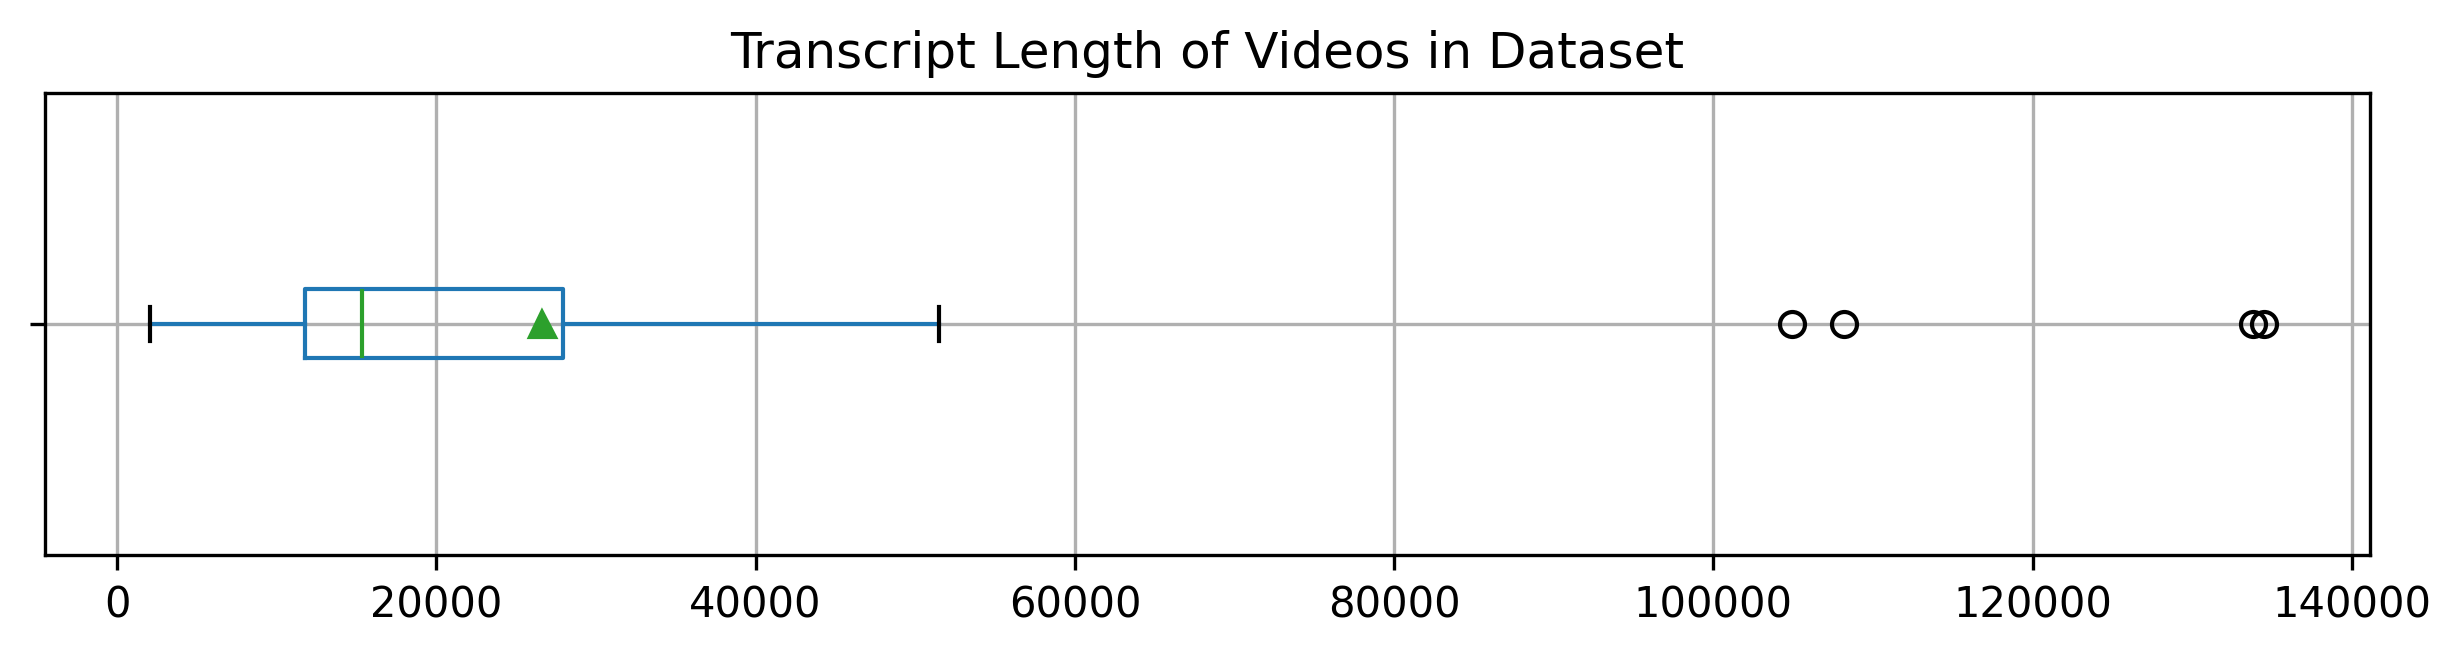

In [113]:
transcript_lengths = []
for video_url in video_urls:
    semantic_chapter_per_video_df = semantic_chapter_df[
        (semantic_chapter_df['video_url'] == video_url)
    ]
    human_chapters_transcript_per_video_df = human_chapters_transcript_df[
        (human_chapters_transcript_df['video_url'] == video_url)
    ]
    transcript_text = ' '.join(human_chapters_transcript_per_video_df['chapter_text'].tolist())

    print(f"The length of the original video transcript is '{len(transcript_text)}' chars")
    print(
        f"The length of the semantic chapters for video '{video_url}' is '{len(' '.join(semantic_chapter_per_video_df['chapter_text'].to_list()))}' chars")
    print(
        f"The length of the human chapters for video '{video_url}' is '{len(' '.join(human_chapters_transcript_per_video_df['chapter_text'].to_list()))}' chars")
    transcript_lengths.append({"transcript_length": len(transcript_text)})
    print("-" * 100)

transcript_lengths_df = pd.DataFrame(transcript_lengths)
fig, ax = plt.subplots(figsize=(10, 2), dpi=300)
transcript_lengths_df.boxplot(column='transcript_length', vert=False, showmeans=True, ax=ax)
ax.set_title('Transcript Length of Videos in Dataset')
plt.suptitle('')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels([])
plt.show()

Step 2: Rate the human titles based on their transcript

In [114]:
human_title_ratings_df = pd.DataFrame(columns=['video_url', 'title', 'rating', 'arguments'])

for video_url in video_urls:
    title_rating_prompt = PromptTemplate(
        input_variables=['title', 'chapter_text'],
        partial_variables={'format_instructions': output_parser.get_format_instructions()},
        template="""
    Given the following chapter's text and its title, rate how well the title summarises the chapter from 0 to 100, where 0 is the worst and 100 is the best. Provide arguments why the rating is chosen.
    
    Chapter Text:
    {chapter_text}
    
    Chapter Title:
    {title}
    
    {format_instructions}
    """
    )
    
    human_title_ratings_per_video_data = []

    human_chapters_transcript_per_video_df = human_chapters_transcript_df[human_chapters_transcript_df['video_url'] == video_url]
    
    for _, chapter in human_chapters_transcript_per_video_df.iterrows():
        try:
            response = (title_rating_prompt | structured_model).invoke({
                "title": chapter['title'],
                "chapter_text": chapter['chapter_text']
            })
            human_title_ratings_per_video_data.append({
                'video_url': video_url,
                'title': chapter['title'],
                'rating': response.rating,
                'arguments': response.arguments
            })
        except Exception as e:
            print(f"Error rating title '{chapter['title']}' for video '{video_url}': {e}")
            human_title_ratings_per_video_data.append({
                'video_url': video_url,
                'title': chapter['title'],
                'rating': None,
                'arguments': str(e)
            })
    human_title_ratings_per_video_df = pd.DataFrame(human_title_ratings_per_video_data)
    #print(f"Human title and rating for video '{video_url}':")
    #display(human_title_ratings_per_video_df)
    human_title_ratings_df = pd.concat([human_title_ratings_df, human_title_ratings_per_video_df]).reset_index(drop=True)

In [115]:
display(human_title_ratings_df)

,video_url,title,rating,arguments
0,-xjZ54TFT2o,Intro,20,"The title 'Intro' is very vague and does not provide any specific information about the content of the chapter. The chapter text discusses a specific company's greenwashing campaign, the impact of such campaigns, and the broader implications of corporate responsibility and environmental marketing. A more appropriate title would reflect these themes. 'Intro' fails to capture the essence of the chapter, making it an inadequate summary."
1,-xjZ54TFT2o,What Companies Claim They're Doing,85,"The title 'What Companies Claim They're Doing' is quite effective in summarizing the chapter. The chapter discusses how companies, particularly Chevron, have used marketing campaigns to project an environmentally friendly image while their actual practices are harmful to the environment. The title accurately reflects the theme of companies making claims about their environmental initiatives. However, it could be slightly improved by explicitly mentioning the concept of 'greenwashing' to make it even clearer. Hence, the rating of 85."
2,-xjZ54TFT2o,Why Companies Greenwash,95,"The title 'Why Companies Greenwash' is highly effective in summarizing the chapter. The chapter delves deeply into the motivations behind corporate greenwashing, explaining how companies use it as a tool to maintain and expand profits while avoiding substantial changes to their business practices. It also discusses the broader implications of greenwashing, such as shifting the narrative around climate action and creating a false sense of security among consumers. The title succinctly captures the essence of these discussions. However, it could be slightly improved by hinting at the broader consequences of greenwashing, which is why it doesn't receive a perfect score."
3,-xjZ54TFT2o,Why Corporations Won't Save Us,95,"The chapter title 'Why Corporations Won't Save Us' effectively summarizes the chapter's content, which details various instances of corporations engaging in environmentally destructive practices while falsely promoting themselves as environmentally friendly. The chapter provides specific examples of companies like Chevron, Home Depot, and Nestle, illustrating how their actions contradict their public claims of sustainability and social responsibility. The title captures the essence of the chapter's argument that corporations prioritize profit over genuine environmental and social good, making it a highly accurate summary. The only minor improvement could be a slight emphasis on the deceptive practices, but overall, the title is highly fitting."
4,-xjZ54TFT2o,How We Change,60,"The title 'How We Change' is somewhat relevant to the chapter's content, as it touches on the need for systemic change and harm-reduction strategies. However, the title is quite vague and does not specifically address the main focus of the chapter, which is the critique of capitalism, greenwashing, and corporate social responsibility. A more precise title would better capture the essence of the chapter and its arguments about the necessity of ending capitalism and implementing harm-reduction strategies in the meantime."
...,...,...,...,...
565,z0e76N-wMz0,"Types of waves (longitudinal, transverse, etc.)",90,"The title 'Types of waves (longitudinal, transverse, etc.)' is quite accurate in summarizing the chapter. The chapter text discusses various types of waves, including longitudinal, transverse, torsional, water waves, and even traffic waves. It provides examples and explanations for each type, which aligns well with the 'etc.' in the title. However, the title could be slightly more descriptive to capture the full range of wave types discussed, such as mentioning torsional and water waves explicitly. Therefore, the rating is 90."
566,z0e76N-wMz0,Interference,95,"The chapter title 'Interference' is highly appropriate and accurately summarizes the content of the chapter. The entire text is dedicated to explaining the concept of wave 

Calculate how well humans title their chapters

,video_url,average_rating
0,-xjZ54TFT2o,77.86
1,2XGREPnlI8U,83.71
2,2kYqITsbK5U,75.00
3,3-mLD6JBfl8,80.38
4,3yiT_WMlosg,81.00
5,423Hu1I5wa8,74.17
6,53nDh4_GhA8,73.57
7,6R179MBYMhY,57.14
8,8bL050WTT1s,78.00
9,BuBDmIRThtk,74.77


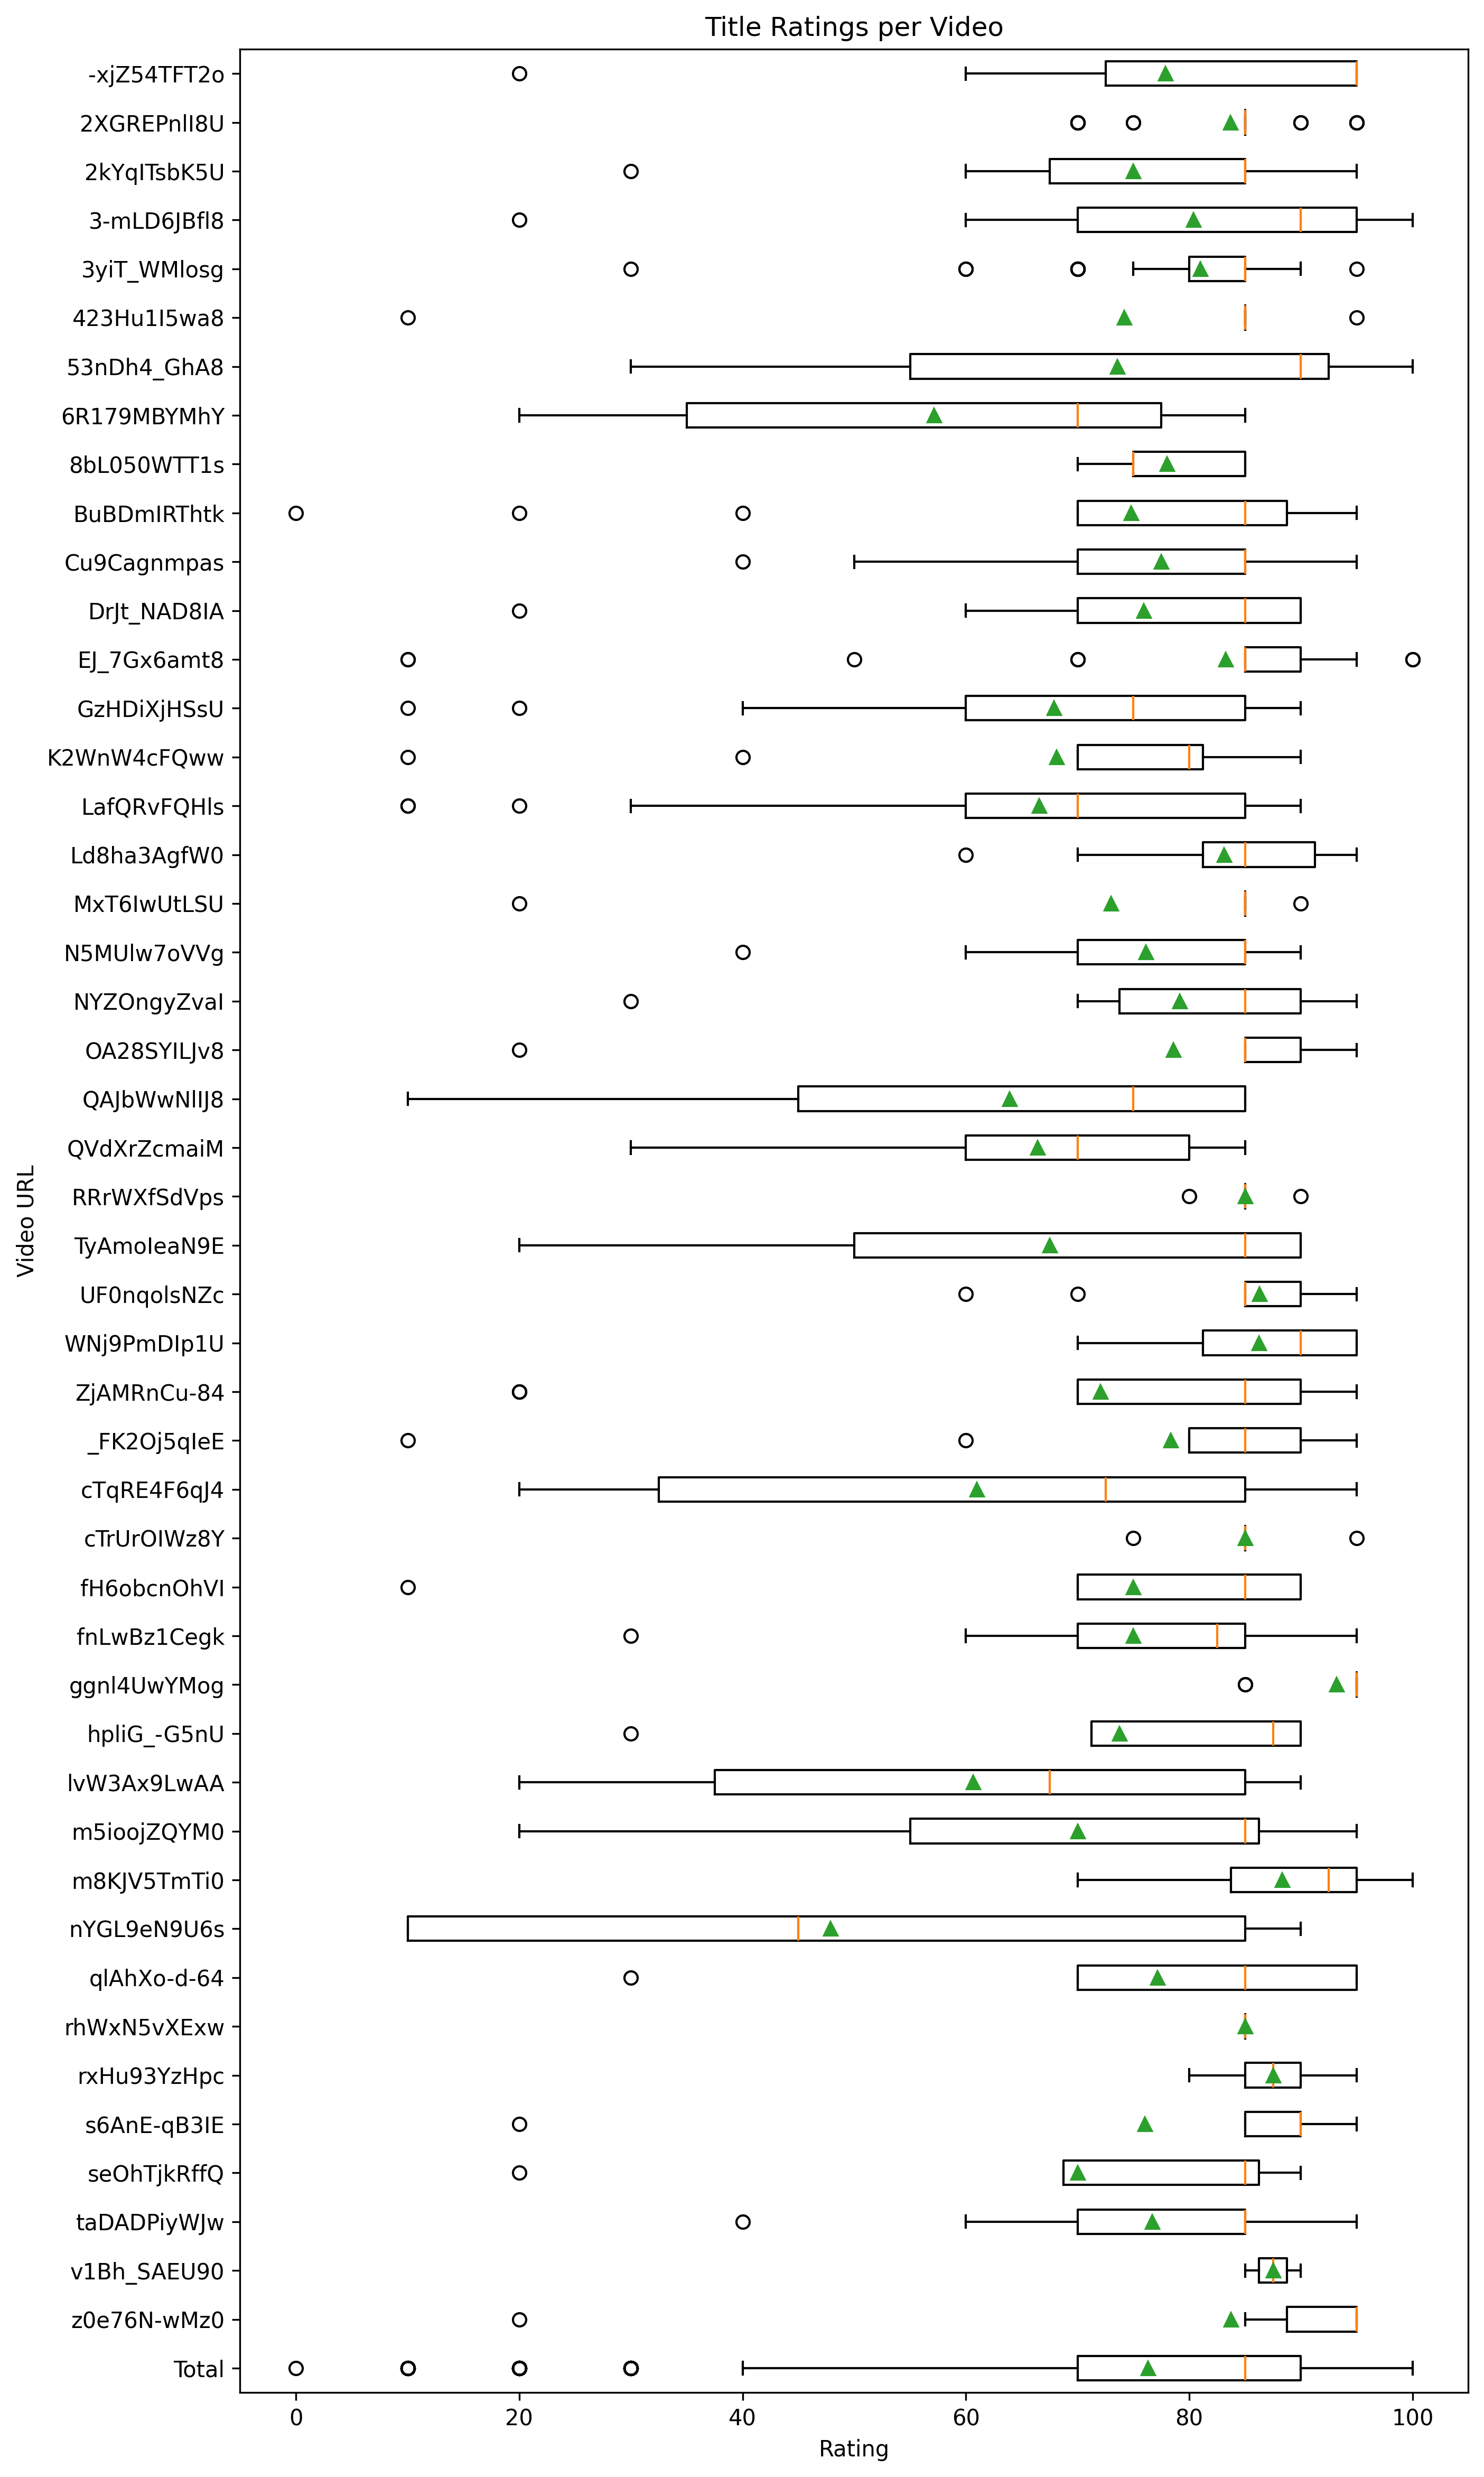

In [116]:
average_ratings_df = human_title_ratings_df.groupby('video_url', as_index=False)['rating'].mean()
average_ratings_df.rename(columns={'rating': 'average_rating'}, inplace=True)
average_ratings_df.reset_index(drop=True, inplace=True)
overall_average = average_ratings_df['average_rating'].mean()

overall_row = pd.DataFrame([{'video_url': 'Total Average', 'average_rating': overall_average}])

average_ratings_df = pd.concat([average_ratings_df, overall_row]).reset_index(drop=True)
# We sometimes have ints
average_ratings_df['average_rating'] = average_ratings_df['average_rating'].astype(float).round(2)
display(average_ratings_df)

overall_df = human_title_ratings_df.copy()
overall_df['video_url'] = 'Total'
human_title_ratings_with_overall = pd.concat([human_title_ratings_df, overall_df]).reset_index(drop=True)

# For some awful reason explicit reverse order is the only way to order boxplot correctly
keep_index_order = human_title_ratings_with_overall['video_url'].unique().tolist()[::-1]
grouped_data = [human_title_ratings_with_overall[human_title_ratings_with_overall['video_url'] == category]['rating'] for category in keep_index_order]

fig, ax = plt.subplots(figsize=(10, 0.4*len(keep_index_order)), dpi=300)
ax.boxplot(grouped_data, vert=False, showmeans=True, tick_labels=keep_index_order)


ax.set_title('Title Ratings per Video')
plt.suptitle('')
ax.set_xlabel('Rating')
ax.set_ylabel('Video URL')
plt.show()

Step 3: Rate how well the chapters divide the whole content

In [117]:
chapter_division_ratings_df = pd.DataFrame(columns=['video_url', 'division_type', 'rating', 'arguments'])

for video_url in video_urls:
    chapter_division_ratings_per_video_data = []

    human_chapters_transcript_per_video_df = human_chapters_transcript_df[
        (human_chapters_transcript_df['video_url'] == video_url)
    ]
    transcript_text = ' '.join(human_chapters_transcript_per_video_df['chapter_text'].tolist())

    human_chapters_transcript_per_video_df = human_chapters_transcript_df[
        human_chapters_transcript_df['video_url'] == video_url]

    human_chapters_str = ''
    for _, chapter in human_chapters_transcript_per_video_df.iterrows():
        human_chapters_str += f"Chapter {chapter.index}:\nTitle: {chapter['title']}\nText: {chapter['chapter_text']}\n\n"

    semantic_chapter_transcript_per_video_df = semantic_chapter_df[
        semantic_chapter_df['video_url'] == video_url]
    
    semantic_chapters_str = ''
    for _, chapter in semantic_chapter_transcript_per_video_df.iterrows():
        semantic_chapters_str += f"Chapter {chapter.index}:\nTitle: {chapter['title']}\nText: {chapter['chapter_text']}\n\n"

    division_rating_prompt = PromptTemplate(
        input_variables=['chapters', 'whole_transcript'],
        partial_variables={'format_instructions': output_parser.get_format_instructions()},
        template="""
Given the entire transcript of a video and its division into chapters with titles and texts, rate how well this division segments the content into coherent and meaningful chapters from 0 to 100, where 0 is the worst and 100 is the best. Provide arguments why the rating is chosen.

Entire Transcript:
{whole_transcript}

Chapters:
{chapters}

{format_instructions}
"""
    )
    
    # Rate human chapter division
    try:
        human_division_response = (division_rating_prompt | structured_model).invoke({
            "chapters": human_chapters_str,
            "whole_transcript": transcript_text
        })
        chapter_division_ratings_per_video_data.append({
            'video_url': video_url,
            'division_type': 'human',
            'rating': human_division_response.rating,
            'arguments': human_division_response.arguments
        })
    except Exception as e:
        print(f"Error rating human chapters division: {e}")
        chapter_division_ratings_per_video_data.append({
            'video_url': video_url,
            'division_type': 'human',
            'rating': None,
            'arguments': str(e)
        })
    
    # Rate semantic chapter division
    try:
        semantic_division_response = (division_rating_prompt | structured_model).invoke({
            "chapters": semantic_chapters_str,
            "whole_transcript": transcript_text
        })
        chapter_division_ratings_per_video_data.append({
            'video_url': video_url,
            'division_type': 'semantic',
            'rating': semantic_division_response.rating,
            'arguments': semantic_division_response.arguments
        })
    except Exception as e:
        print(f"Error rating semantic chapters division: {e}")
        chapter_division_ratings_per_video_data.append({
            'video_url': video_url,
            'division_type': 'semantic',
            'rating': None,
            'arguments': str(e)
        })
    chapter_division_ratings_per_video_df = pd.DataFrame(chapter_division_ratings_per_video_data)
    #print(f"Chapter division ratings for video '{video_url}':")
    #display(chapter_division_ratings_per_video_df)
    chapter_division_ratings_df = pd.concat([chapter_division_ratings_df, chapter_division_ratings_per_video_df]).reset_index(
        drop=True)

Standalone rating of division of transcript into chapters

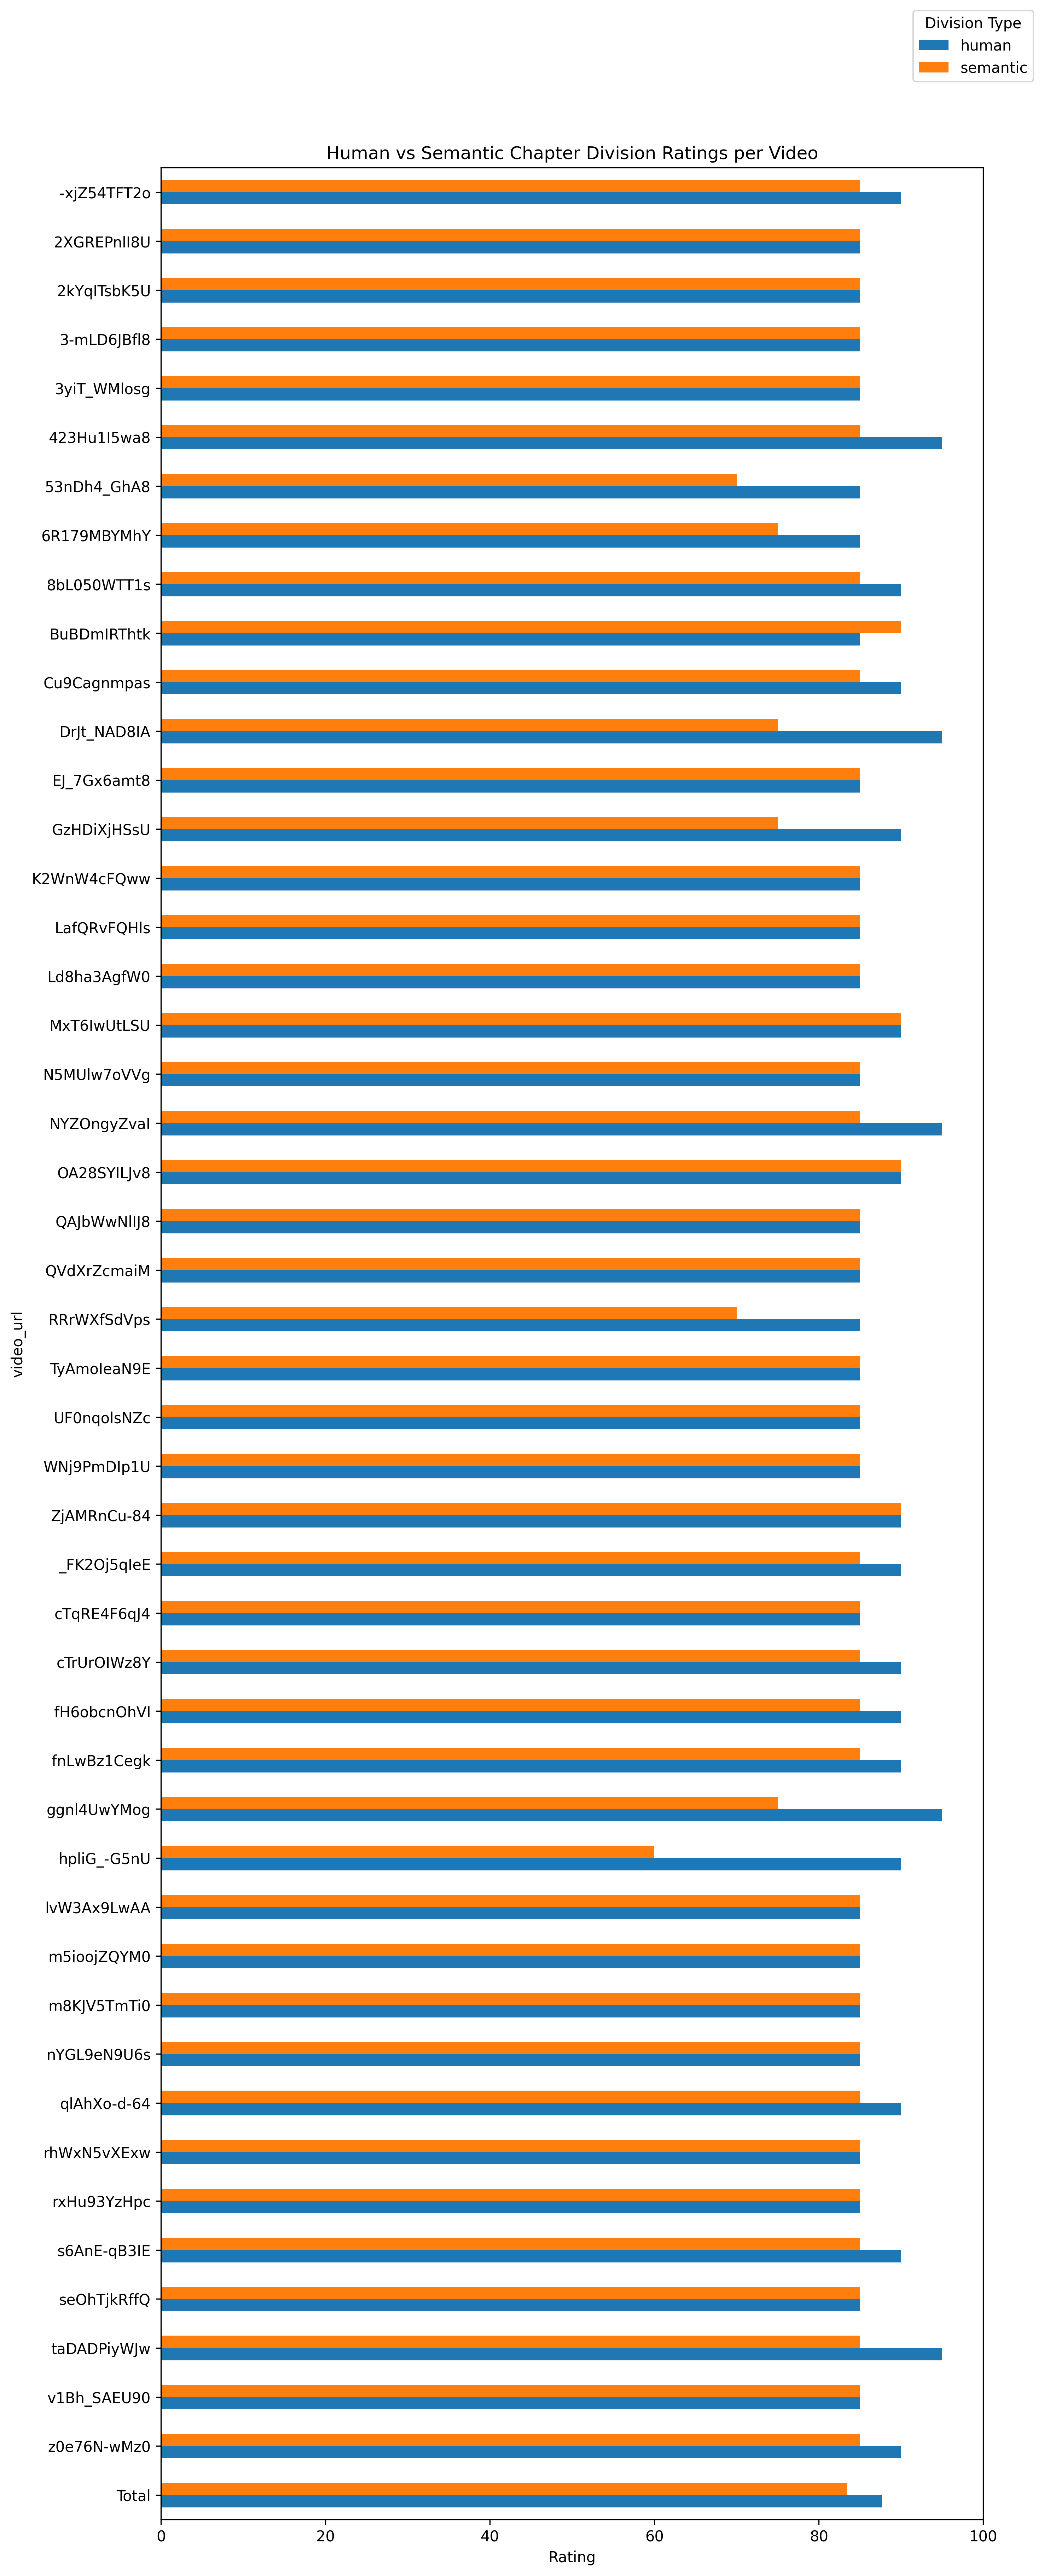

In [118]:
average_ratings_division_df = chapter_division_ratings_df.groupby('division_type', as_index=False)['rating'].mean()

average_ratings_division_df['video_url'] = 'Total'
#average_ratings_division_df.rename(columns={'rating': 'average_rating'}, inplace=True)

#display(average_ratings_division_df)

human_vs_semantic = pd.concat([chapter_division_ratings_df, average_ratings_division_df]).reset_index(drop=True)
# Don't sort when pivoting
human_vs_semantic_pivot = human_vs_semantic.pivot_table(index='video_url', columns='division_type',values='rating', aggfunc='mean', sort=False)
# Reverse original order
# For some awful reason explicit reverse order is the only way to order bar charts correctly, too
keep_index_order = human_vs_semantic_pivot.index.tolist()[::-1]
human_vs_semantic_pivot = human_vs_semantic_pivot.reindex(keep_index_order)

fig, ax = plt.subplots(figsize=(10, 0.6 * len(keep_index_order)), dpi=300)
human_vs_semantic_pivot.plot(kind='barh', ax=ax)
ax.set_title('Human vs Semantic Chapter Division Ratings per Video')
plt.suptitle('')
ax.set_xlim(0, 100)
ax.set_xlabel('Rating')
plt.legend(title='Division Type', loc='upper right', bbox_to_anchor=(1.07, 1.07))
plt.show()

Step 4: Evaluate how much better/worse the semantic chapters are than the human chapters

In [119]:
compare_chapter_division_df = pd.DataFrame(columns=['video_url', 'rating_semantic_better', 'arguments'])

for video_url in video_urls:
    compare_chapter_division_per_video_data = {}

    human_chapters_transcript_per_video_df = human_chapters_transcript_df[
        (human_chapters_transcript_df['video_url'] == video_url)
    ]
    transcript_text = ' '.join(human_chapters_transcript_per_video_df['chapter_text'].tolist())

    human_chapters_transcript_per_video_df = human_chapters_transcript_df[
        human_chapters_transcript_df['video_url'] == video_url
    ]

    human_chapters_str = ''
    for idx, (_, chapter) in enumerate(human_chapters_transcript_per_video_df.iterrows()):
        human_chapters_str += f"Chapter {idx}:\nText: {chapter['chapter_text']}\n\n"

    semantic_chapter_transcript_per_video_df = semantic_chapter_df[
        semantic_chapter_df['video_url'] == video_url]

    semantic_chapters_str = ''
    for idx, (_, chapter) in enumerate(semantic_chapter_transcript_per_video_df.iterrows()):
        semantic_chapters_str += f"Chapter {chapter.index}:\nText: {chapter['chapter_text']}\n\n"

    comparison_prompt = PromptTemplate(
        input_variables=['human_chapters', 'semantic_chapters', 'whole_transcript'],
        partial_variables={'format_instructions': output_parser.get_format_instructions()},
        template="""
    Given the entire transcript of a video and two different divisions into chapters (Division A and Division B), rate how much better Division B is compared to Division A from 0 to 100, where 0 means Division B is much worse than Division A, 50 means they are equally good, and 100 means Division B is much better than Division A. Provide arguments why the rating is chosen.
    
    Entire Transcript:
    {whole_transcript}
    
    Division A:
    {human_chapters}
    
    Division B:
    {semantic_chapters}
    
    {format_instructions}
    """
    )
    
    # Compare the divisions
    try:
        comparison_response = (comparison_prompt | structured_model).invoke({
            "human_chapters": human_chapters_str,
            "semantic_chapters": semantic_chapters_str,
            "whole_transcript": transcript_text
        })
        compare_chapter_division_per_video_data = {
            'video_url': video_url,
            'rating_semantic_better': comparison_response.rating,
            'arguments': comparison_response.arguments
        }
    except Exception as e:
        print(f"Error comparing divisions: {e}")
        compare_chapter_division_per_video_data = {
            'video_url': video_url,
            'rating_semantic_better': None,
            'arguments': str(e)
        }
    compare_chapter_division_per_video_df = pd.DataFrame(compare_chapter_division_per_video_data, index=[0])
    print(f"Chapter division ratings for video '{video_url}':")
    total_semantic_better = compare_chapter_division_per_video_data["rating_semantic_better"]
    if total_semantic_better < 50:
            print(f"    Semantic chapter division is {total_semantic_better}% worse than human chapter division")
    elif total_semantic_better > 50:
        print(f"    Semantic chapter division is {total_semantic_better - 50}% better than human chapter division")
    else:
        print(f"    Semantic chapter division is equally good to human chapter division")
    print(f"    The reason for the rating is:\n{compare_chapter_division_per_video_data['arguments'][:320]}...")
    print("-" * 100)
    compare_chapter_division_df = pd.concat(
        [compare_chapter_division_df, compare_chapter_division_per_video_df]).reset_index(
        drop=True)

Chapter division ratings for video '-xjZ54TFT2o':
    Semantic chapter division is 5% better than human chapter division
    The reason for the rating is:
Division B is slightly better than Division A because it breaks down the content into more granular sections, which can help viewers follow the narrative more easily. However, the improvement is not substantial enough to warrant a significantly higher rating. Both divisions cover the same key points and maintain the ov...
----------------------------------------------------------------------------------------------------
Chapter division ratings for video '2XGREPnlI8U':
    Semantic chapter division is 25% better than human chapter division
    The reason for the rating is:
Division B is significantly better than Division A for several reasons. Firstly, Division B breaks down the content into smaller, more manageable chapters, making it easier for the audience to follow and digest the information. This is particularly important given

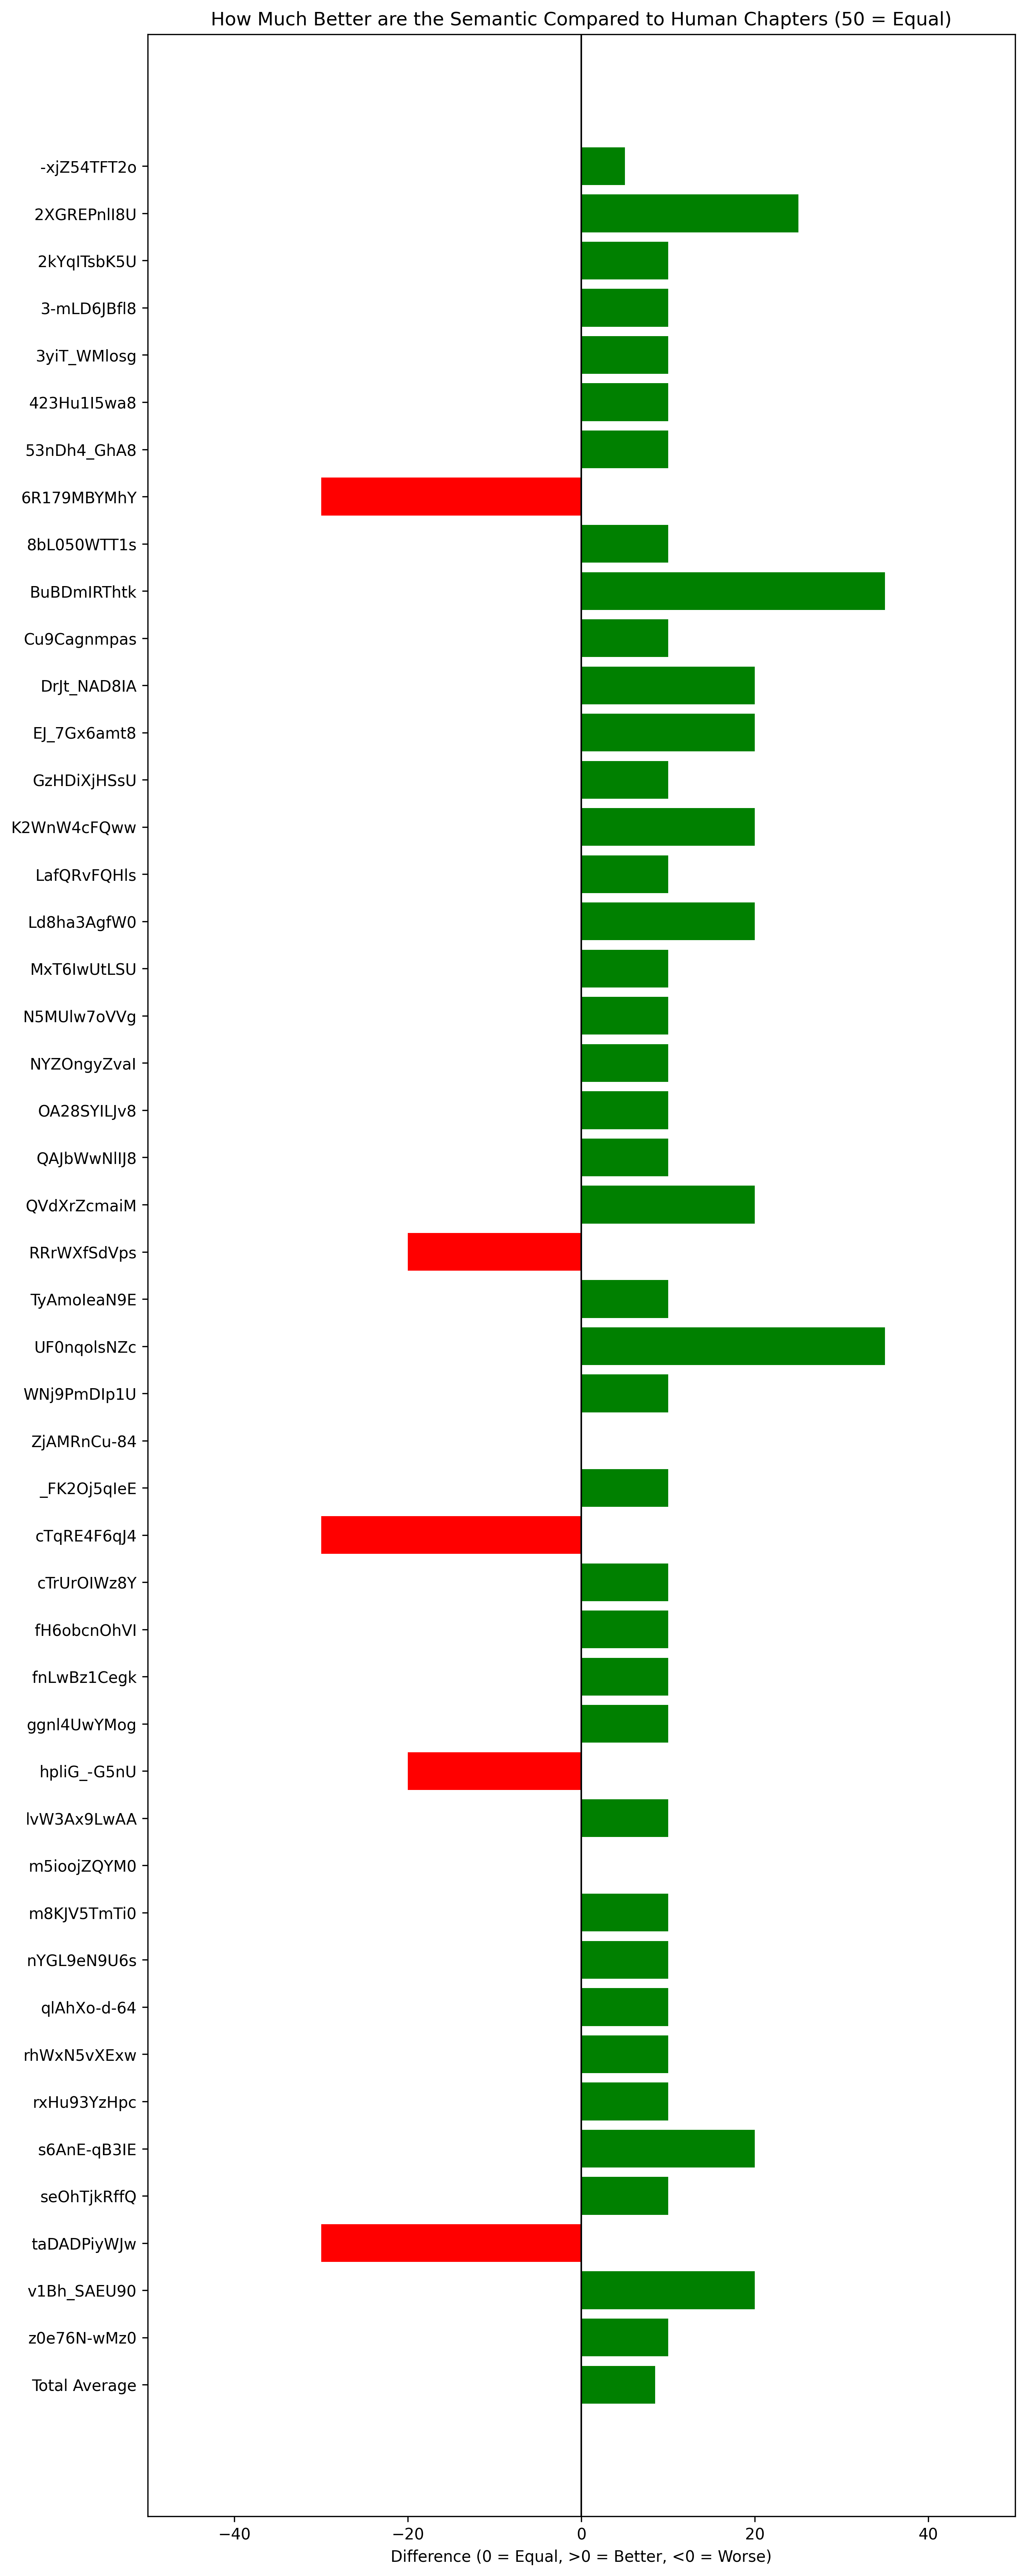

In [120]:
total_average = compare_chapter_division_df['rating_semantic_better'].mean()

compare_chapter_division_with_total_avg = pd.concat([
    compare_chapter_division_df,
    pd.DataFrame({'video_url': 'Total Average', 'rating_semantic_better': total_average, 'arguments': ''}, index=[0]),
]).reset_index(drop=True)

# Reverse original order
# For some awful reason explicit reverse order is the only way to order bar charts correctly, too
keep_index_order = compare_chapter_division_with_total_avg.index.tolist()[::-1]
compare_chapter_division_with_total_avg = compare_chapter_division_with_total_avg.reindex(keep_index_order)

fig, ax = plt.subplots(figsize=(10, 0.6 * len(keep_index_order)), dpi=300)

bars = ax.barh(compare_chapter_division_with_total_avg['video_url'],
               compare_chapter_division_with_total_avg['rating_semantic_better'] - 50,
               color=['green' if rating > 50 else 'red' for rating in
                      compare_chapter_division_with_total_avg['rating_semantic_better']])

ax.axvline(0, color='black', linewidth=1)
ax.set_title('How Much Better are the Semantic Compared to Human Chapters (50 = Equal)')
ax.set_xlabel('Difference (0 = Equal, >0 = Better, <0 = Worse)')
ax.set_xlim(-50, 50)
plt.show()

Comparison between semantic chapter vs human chapter division

In [122]:
import numpy as np
from scipy.stats import norm
from scipy import stats

equality_point = 50

t_stat, p_value = stats.ttest_1samp(compare_chapter_division_df['rating_semantic_better'].astype(float), equality_point)

print(f"T-statistic: {t_stat}, P-value: {p_value}")
alpha = 0.05
power = 0.8

mean_rating = compare_chapter_division_df['rating_semantic_better'].mean()

if p_value < alpha:
    print(f"Reject the null hypothesis: The mean rating is significantly different from {equality_point}.")
    if mean_rating > equality_point:
        print("Conclusion:")
        print(" Semantic chapter division is significantly better than human chapter division.")
        print(f" Semantic chapter division is around {(mean_rating - equality_point).round(2)}% better than human chapter division")
    else:
        print("Conclusion:")
        print(" Semantic chapter division is significantly worse than human chapter division.")
        print(f" Semantic chapter division is {mean_rating.round(2)}% worse than human chapter division")
else:
    print(f"Fail to reject the null hypothesis: The mean rating is not significantly different from {equality_point}.")
    print('Conclusion:')
    print(" No significant difference between semantic and human chapter division.")
    
    # Calculate needed sample size in order to verify that we are not falsely accepting H0
    # The mean is 50 - equal, any difference is 50 - value
    sigma = (equality_point - compare_chapter_division_df['rating_semantic_better']).std()
    delta = abs(equality_point - mean_rating)
    
    z_alpha = norm.ppf(1 - alpha / 2)
    z_beta = norm.ppf(power)
    
    sample_size_req_per_group = (2 * (sigma ** 2) * (z_alpha + z_beta) ** 2) / (delta ** 2)
    sample_size_req_per_group = np.ceil(sample_size_req_per_group)
    
    print(f"Required sample size per group: {sample_size_req_per_group}")
    
    if sample_size_req_per_group * 2 > sample_size:
        print(f"Sample size not big enough: {sample_size_req_per_group * 2}")


T-statistic: 4.195645856375, P-value: 0.00012284838644660177
Reject the null hypothesis: The mean rating is significantly different from 50.
Conclusion:
 Semantic chapter division is significantly better than human chapter division.
 Semantic chapter division is around 8.51% better than human chapter division
